In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [7]:
from interpretableai import iai

In [329]:
sns.set_theme(style='white', palette='tab10', font_scale=1.3)

In [330]:
f = lambda x1, x2: 0.2*np.log(x1) + 0.4*np.log(x2)
g1 = lambda x1, x2: 1*(0.43*np.log(x1-0.5)+1.1+x1-x2>0)
g2 = lambda x1, x2: 1*(x2+0.35*np.log(x1)-2*x1**2+0.6>0)
g3 = lambda x1, x2: 1*(-x2+1.1*x1+0.4>0)
g4 = lambda x1, x2: 1*(-x2-1.5*x1+2.6>0)

g = lambda x1, x2: g1(x1,x2)*g2(x1,x2)*g3(x1,x2)*g4(x1,x2)
g34 = lambda x1, x2: g3(x1,x2)*g4(x1,x2)

In [352]:
def cmap_gen(color):
    return LinearSegmentedColormap.from_list('foo', ['w',color], 2)
    
def draw_contour(func, x1_lim, x2_lim, cm=None, N = 1000, ax=None, fig=None, contour=False, lname='', **kwargs):
    
    if cm is None:
        cm = LinearSegmentedColormap.from_list('foo', ['w','tab:orange'], 2)
        
    if ax is None and fig is None:
        fig = plt.figure()
        ax = fig.add_subplot()

    x1 = np.linspace(x1_lim[0],x1_lim[1], N)
    x2 = np.linspace(x2_lim[0],x2_lim[1], N)

    x1m, x2m = np.meshgrid(x1, x2)
    
    z = func(x1m, x2m)
    

    #else:
    alpha = 0.2 
    if 'alpha' in kwargs: 
        alpha = kwargs['alpha']
        del kwargs['alpha']
    
    cntr = ax.contourf(x1,x2,z,cmap=cm,alpha=alpha, **kwargs)
    
    if contour:
        if 'alpha' in kwargs: 
            del kwargs['alpha']
        cntr = ax.contour(x1,x2,z,cmap=cm, **kwargs)
    
    return fig, ax, cntr

def draw_contour_from_df(dfl, x1_lim, x2_lim, cm=None, ax=None, fig=None, contour=False, lname='', **kwargs):
    if cm is None:
        cm = LinearSegmentedColormap.from_list('foo', ['w','tab:orange'], 2)
        
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    
    x1,x2,y = dfl['x[1]'].to_numpy(),dfl['x[2]'].to_numpy(), dfl['Y'].to_numpy() 
    
    x1 = x1.reshape((np.sqrt(x1.shape[0]).astype(np.int32), -1)).T
    x2 = x2.reshape((np.sqrt(x2.shape[0]).astype(np.int32), -1)).T
    y = y.reshape((np.sqrt(y.shape[0]).astype(np.int32), -1)).T

    
    

    alpha = 0.2 
    if 'alpha' in kwargs: 
        alpha = kwargs['alpha']
        del kwargs['alpha']
    cntr = ax.contourf(x1, x2, y, cmap=cm, alpha=alpha, **kwargs)
    
    if contour:
        if 'alpha' in kwargs: 
            del kwargs['alpha']
        cntr = ax.contour(x1, x2, y, cmap=cm, **kwargs)
        
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(x1_lim)
    ax.set_ylim(x2_lim)
    return fig, ax, cntr

def draw_scatter(df, x, y, label, color_map=None, ax=None, fig=None):
    
    ax.autoscale(False)
    
    for val in sorted(df[label].unique(), reverse=True):
        df_sub = df[df[label] == val]
        xx, yy = df_sub[x].to_numpy(), df_sub[y].to_numpy()
        ax.scatter(xx, yy, label=val, edgecolors='white', marker='o', s=60)

def full_draw_constraint(df, func, x1_lim, x2_lim, ax=None, fig=None):
    cm = LinearSegmentedColormap.from_list('foo', ['w','tab:orange'], 2)

    fig, ax, cntr = draw_contour(func, x1_lim, x2_lim, cm, fig=fig, ax=ax)
    draw_scatter(df, 'x[1]', 'x[2]', 'feasible', fig=fig, ax=ax)

    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    return fig, ax, cntr

In [332]:
x1_lim = (0.51, 3)
x2_lim = (0.3, 3)#(0.01, 3)

x1_lim = (0.57, 1.3)
x2_lim = (0.3, 2.7)#(0.01, 3)

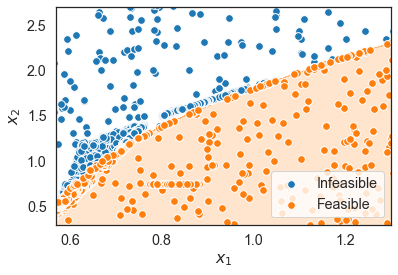

In [333]:
i = 2

df = pd.read_csv(f'./oct_sampling/main_{i}.csv')
#dfl = pd.read_csv(f'./lnr_{i}.csv')
df['feasible'] = df['Y'].apply(lambda x: '$g_1(x)\leq 0$ feasible' if x>0 else '$g_1(x)\leq 0$ infeasible')
df['feasible'] = df['Y'].apply(lambda x: 'Feasible' if x>0 else 'Infeasible')

#sns.scatterplot(data=df, x='x[1]', y='x[2]', hue='feasible')
fig, ax, _ = full_draw_constraint(df, g1, x1_lim, x2_lim)

In [334]:
def random_turn_off_positives(mask, ratio=0.3):
    tmp_mask = mask[mask]
    smpl = tmp_mask.sample(int(ratio*tmp_mask.shape[0])).index
    
    mask[smpl] = False
    
    return mask
    

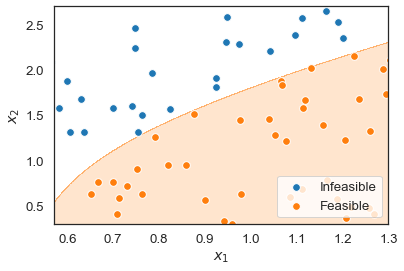

In [348]:
m1 = random_turn_off_positives(df['s_label'].isin(['lh_sample']), ratio=0.8)

fig, ax, _ = full_draw_constraint(df[m1], g1, x1_lim, x2_lim)

#plt.savefig("oct_sampling/a1.svg", format='svg')
plt.savefig("oct_sampling/a1.png", dpi=300)

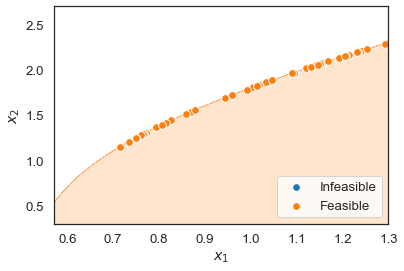

In [349]:
m2 = random_turn_off_positives(df['s_label'].isin(['knn']), ratio=0.1)

fig, ax, _ = full_draw_constraint(df[m2], g1, x1_lim, x2_lim)

#plt.savefig("oct_sampling/a2.svg", format='svg')
plt.savefig("oct_sampling/a2.png", dpi=300)

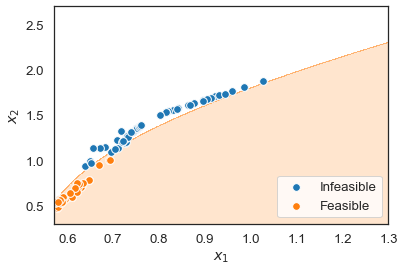

In [350]:
m3 = random_turn_off_positives(df['s_label'].isin(['oct']), ratio=0.952)#0.965

fig, ax, _ = full_draw_constraint(df[m3], g1, x1_lim, x2_lim)

#plt.savefig("oct_sampling/a3.svg", format='svg')
plt.savefig("oct_sampling/a3.png", dpi=300)

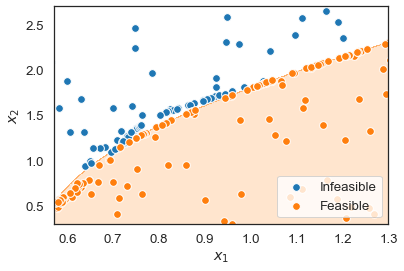

In [351]:
fig, ax, _ = full_draw_constraint(df[m1 | m2 | m3], g1, x1_lim, x2_lim)

#plt.savefig("oct_sampling/a4.svg", format='svg')
plt.savefig("oct_sampling/a4.png", dpi=300)

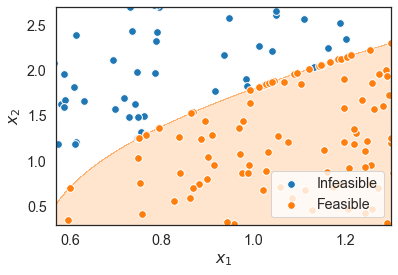

In [339]:
fig, ax, _ = full_draw_constraint(df[df['s_label'].isin(['lh_sample', 'knn'])].sample(500), g1, x1_lim, x2_lim)

## IAI preds

In [340]:
N = 500

In [341]:
#for i in range(8):
    
i = 1



In [342]:

x1 = np.linspace(x1_lim[0],x1_lim[1], N)
x2 = np.linspace(x2_lim[0],x2_lim[1], N)

x1m, x2m = np.meshgrid(x1, x2)

X = np.vstack([x1m.reshape(-1), x2m.reshape(-1)]).T
dfX = pd.DataFrame(X, columns=['x[1]','x[2]'])

preds = []

In [343]:
for i in range(1,8):
    
    name = f'oct_exports/lnr_bbl2_{i}.json'
    model = iai.read_json(name)
    
    Y = model.predict(dfX)

    preds.append(Y)

preds = np.array(preds)
pred_sum = preds.sum(axis=0)
discord = np.minimum(pred_sum, preds.shape[0]-pred_sum)

In [344]:
dfX['Y'] = (discord > 1)
#dfX['Y'] = dfX.apply(lambda x: 0 if (x['x[2]']> 1.4) and (x['x[1]']>0.5) else x['Y'],axis=1)
dfX['Y'] = dfX.apply(lambda x: 0 if (x['x[2]']> 1.4) and (x['x[1]']>1) else x['Y'],axis=1)

C:\Users\marga\AppData\Local\Temp/ipykernel_23976/3058025216.py:57: UserWarning: linewidths is ignored by contourf
  cntr = ax.contourf(x1, x2, y, cmap=cm, alpha=alpha, **kwargs)


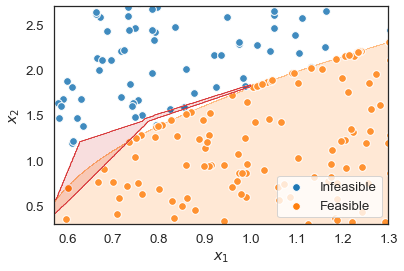

In [378]:
#fig, ax, cntr1 = draw_contour(g1, x1_lim, x2_lim, cm=cmap_gen('tab:orange'))

#sns.set(font_scale=1.5)
sns.set_theme(style='white', palette='tab10', font_scale=1.2)
#sns.set_style("white")
#sns.set_context("notebook", font_scale=1.25)
#sns.set_palette("tab10")

np.random.seed(100)
fig, ax, cntr1 = full_draw_constraint(df[df['s_label'].isin(['lh_sample', 'knn'])].sample(600), g1, x1_lim, x2_lim)

_, _, cntr2 = draw_contour_from_df(dfX, x1_lim, x2_lim, cm=cmap_gen('tab:red'), fig=fig, ax=ax, contour=True, alpha=0.15, linewidths=0.5) # , cm=cmap_gen('tab:orange')
#, linestyles='dashed'
# h1,_ = cntr1.legend_elements()
# h2,_ = cntr2.legend_elements()
# ax.legend([h1[0], h2[0]], ['Contour 1', 'Contour 2'])

# proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
#     for pc in [cntr1.collections[-1], cntr2.collections[-4]]]

#plt.legend(proxy, ["Feasible Region", "High learner disagreement"])

# Combine existing handles with the custom handle
custom_rect = plt.Rectangle((0,0),1,1,fc = 'tab:red', alpha=0.2,  edgecolor='black', linewidth=2)
handles, labels =ax.get_legend_handles_labels()
#handles.append(custom_rect)
#labels.append('Uncertain Region')

plt.legend(handles=handles, labels=labels, loc='lower right')

# plt.savefig("oct_sampling/uncertain.png", dpi=300)
plt.savefig("oct_sampling/uncertain.svg", format='svg')

In [363]:
cntr2.collections[-1]#.get_facecolor()

In [218]:
proxy

In [136]:
cntr1.collections[7].get_facecolor()

IndexError: list index out of range

In [120]:
ax.legend()

No handles with labels found to put in legend.


In [45]:
X.shape

(10000, 2)

In [46]:
model.predict(dfX)

array([0., 1., 1., ..., 1., 1., 1.])

In [47]:
model.predict(dfX)

array([0., 1., 1., ..., 1., 1., 1.])

In [21]:
X.shape

(1000, 2000)

In [17]:
model.predict()

<bound method SupervisedLearner.predict of Fitted OptimalTreeClassifier:
  1) Split: 0.3413 * x[1] - 0.07865 * x[2] < 0.1517
    2) Predict: 0.0 (99.95%), [1878,1], 1879 points, error 0.0005322
    3) Split: -0.4029 * x[1] + 0.2513 * x[2] < 0.0591
      4) Predict: 1.0 (99.77%), [2,859], 861 points, error 0.002323
      5) Predict: 0.0 (100.00%), [56,0], 56 points, error 0>

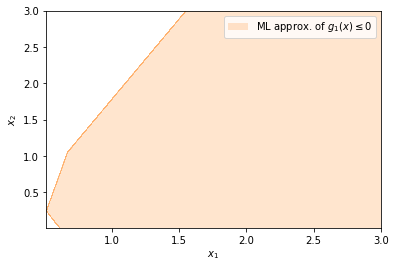

In [491]:
#fig, ax = draw_contour(g1, x1_lim, x2_lim, cm)
#draw_contour_from_df(dfl, x1_lim, x2_lim, ax=ax, fig=fig, cm=cmap_gen('tab:blue'))
fig, ax, cnt = draw_contour_from_df(dfl, x1_lim, x2_lim, cm=cmap_gen('tab:orange'))
ax.legend([cnt.legend_elements()[0][-1]], ['ML approx. of $g_1(x)\leq 0$'])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

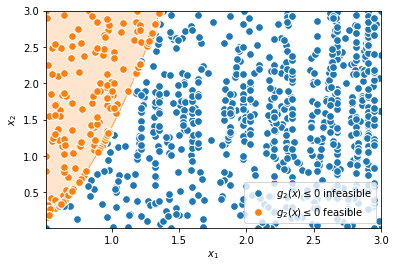

In [492]:
i = 3

df = pd.read_csv(f'./main_{i}.csv')
df['feasible'] = df['Y'].apply(lambda x: '$g_2(x)\leq 0$ feasible' if x>0 else '$g_2(x)\leq 0$ infeasible')
dfl = pd.read_csv(f'./lnr_{i}.csv')

#sns.scatterplot(data=df, x='x[1]', y='x[2]', hue='feasible')
full_draw_constraint(df, g2, x1_lim, x2_lim)

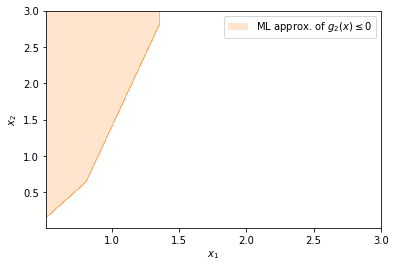

In [493]:
fig, ax, cnt = draw_contour_from_df(dfl, x1_lim, x2_lim)
ax.legend([cnt.legend_elements()[0][-1]], ['ML approx. of $g_2(x)\leq 0$'])

In [487]:
x, y, z = df['x[1]'].to_numpy(), df['x[2]'].to_numpy(), df['feasible'].to_numpy()

#plt.tricontourf(x, y, z, levels=[0, 1])
#sns.displot(data=df, x='x[1]', y='x[2]', hue='feasible',binwidth=0.2)

# Correct and approximation

In [495]:
x1_lim = (0.45, 1.5)
x2_lim = (0, 1.5)

In [496]:
df2 = pd.read_csv(f'./lnr_{2}.csv')
df3 = pd.read_csv(f'./lnr_{3}.csv')

In [497]:
df2['Y'] = df2['Y']*df3['Y']
df2['Y'] = df2['Y']*g34(df2['x[1]'].to_numpy(), df2['x[2]'].to_numpy())

C:\Users\marga\AppData\Local\Temp/ipykernel_37892/2614218318.py:2: RuntimeWarning: invalid value encountered in log
  g1 = lambda x1, x2: 1*(0.43*np.log(x1-0.5)+1.1+x1-x2>0)


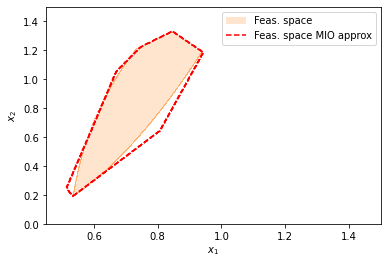

In [498]:
fig, ax, cnt1 = draw_contour(g, x1_lim, x2_lim,  cm=cmap_gen('tab:orange'))
_,_,cnt2 = draw_contour_from_df(df2, x1_lim, x2_lim, cm=cmap_gen('red'), fig=fig, ax=ax, 
                                contour=True, linestyles='dashed')

h1,_ = cnt.legend_elements()
h2,_ = cnt2.legend_elements()

ax.legend([h1[-1], h2[-1]], ['Feas. space', 'Feas. space MIO approx.'])

# Solution path

In [472]:
df_p = pd.read_csv('solution_history.csv')
x1p, x2p = df_p['x[1]'].to_numpy(), df_p['x[2]'].to_numpy()

In [469]:
N = 1000

x1_lim = (0.45, 1)
x2_lim = (0, 1.5)

x1 = np.linspace(x1_lim[0],x1_lim[1], N)
x2 = np.linspace(x2_lim[0],x2_lim[1], N)

x1m, x2m = np.meshgrid(x1, x2)
z = g(x1m, x2m)


C:\Users\marga\AppData\Local\Temp/ipykernel_37892/2614218318.py:2: RuntimeWarning: invalid value encountered in log
  g1 = lambda x1, x2: 1*(0.43*np.log(x1-0.5)+1.1+x1-x2>0)


(0.16783014885289346, 0.3337093333248049)

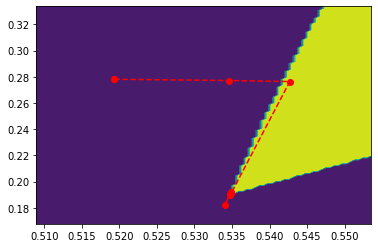

In [470]:
# Create a figure
fig = plt.figure()
ax = fig.add_subplot()

plt.contourf(x1,x2,z)
#plt.scatter(x, y)
plt.plot(x1p, x2p, 'ro', linestyle="--")

# ax.set_xlim(x1_lim)
# ax.set_ylim(x2_lim)

# ax.set_xlim((0.5,0.55))
# ax.set_ylim((0,0.4))

ax.set_xlim((x1p.min()*0.98,x1p.max()*1.02))
ax.set_ylim((x2p.min()*0.92,x2p.max()*1.2))

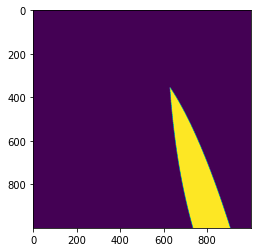

In [28]:
plt.imshow(z)

In [ ]:
ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

C:\Users\marga\AppData\Local\Temp/ipykernel_37892/2614218318.py:2: RuntimeWarning: invalid value encountered in log
  g1 = lambda x1, x2: 1*(0.43*np.log(x1-0.5)+1.1+x1-x2>0)


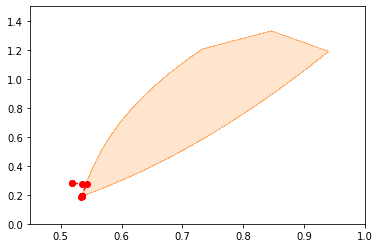

In [502]:
x1_lim = (0.45, 1)
x2_lim = (0, 1.5)

# x1_lim = (x1p.min()*0.95,x1p.max()*1.1)
# x2_lim = (x2p.min()*0.92,x2p.max()*1.2)

fig, ax, cnt1 = draw_contour(g, x1_lim, x2_lim,  cm=cmap_gen('tab:orange'))
ax.plot(x1p, x2p, 'ro', linestyle="--")

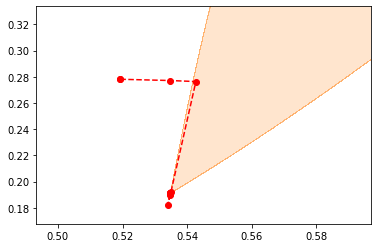

In [501]:
fig
